# 1. Compute the value analytically

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

def integral(a,b):
    return math.log(abs(b + math.sqrt(1 + b**2))) - math.log(abs(a + math.sqrt(1+a**2)))

a = 15
b = 21

S = integral(a,b)
print(f"Analytical: {S}")

Analytical: 0.33592938478094814


# 2. Compute the integral using trapezoidal rule

In [2]:
%%writefile Sequential.py
# Write as py cause without it time it show speedup for each loop (or k in range(N-1))

import math
import numpy as np
import matplotlib.pyplot as plt

def trapezia(a,b):
    N = 1000
    h = (b-a)/N
    S0 = (1/math.sqrt(1 + a**2) + 1/math.sqrt(1 + b**2))*h/2
    S1 = 0
    for k in range(N-1):
        x = a + k*h
        S1 += 1/math.sqrt(1 + x**2)
    return S0 + h*S1

a = 15
b = 21
S = trapezia(a,b)
# print(f'Trapezoidal rule: {S}')

Overwriting Sequential.py


In [3]:
%timeit !mpirun --allow-run-as-root -np 1 python3 Sequential.py

920 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 3. Parallelize using MPI. You should be able to choose any number of MPI processes regardless of the number of discretization points

In [4]:
%%writefile Nazarova_Study_an_integral.py

from mpi4py import MPI
import numpy as np
import math

#Initialization
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def func(x):
    return 1/math.sqrt(1 + x**2)

a = 15
b = 21

N = 1000
h = (b-a)/N
S1 = 0

N_loc = math.ceil(N/size)
a_loc = rank*N_loc

#Main part
if rank != size-1:
    b_loc = (rank+1)*N_loc
else:
    b_loc = N-1

for k in range(a_loc,b_loc):
    x = a + k*h
    S1 += func(x)

S1 = comm.reduce(S1, op = MPI.SUM, root = 0)

if rank == 0:
    S0 = (func(a) + func(b))*h/2
    S = S0 + h*S1

Overwriting Nazarova_Study_an_integral.py


In [5]:
%timeit !mpirun --allow-run-as-root -np 8 python3 Nazarova_Study_an_integral.py

985 ms ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 4. Plot the speedup vs number of processors

Text(0, 0.5, 'speedup, ms')

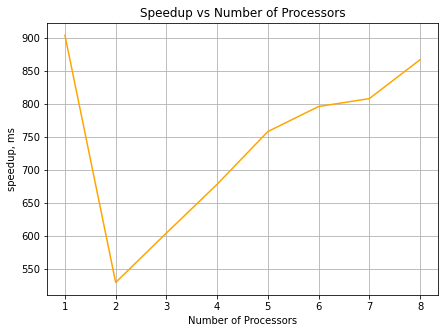

In [6]:
n_of_processors = [1,2,3,4,5,6,7,8]
speedup = [904, 529, 604, 678, 758, 796, 808, 867] #ms

fig = plt.figure(figsize=(7, 5))    
plt.plot(n_of_processors, speedup,color='orange')
plt.grid()
plt.title('Speedup vs Number of Processors')
plt.xlabel('Number of Processors')
plt.ylabel('speedup, ms')

# 5. Plot integration error vs the discretization size

In [7]:
def trapezia(a,b,N):
    h = (b-a)/N
    S0 = (1/math.sqrt(1 + a**2) + 1/math.sqrt(1 + b**2))*h/2
    S1 = 0
    for k in range(N-1):
        x = a + k*h
        S1 += 1/math.sqrt(1 + x**2)
    return S0 + h*S1

Text(0, 0.5, 'Error')

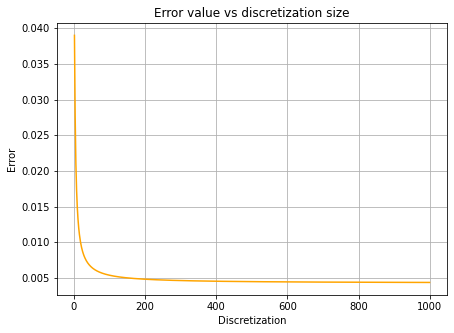

In [8]:
errors = []
N = np.arange(2,1000)

for n in N:
    errors.append(trapezia(a,b,n) - integral(5,7))

fig = plt.figure(figsize=(7, 5))    
plt.plot(N, errors,color='orange')
plt.grid()
plt.title('Error value vs discretization size')
plt.xlabel('Discretization')
plt.ylabel('Error')